In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Import annotation, reference, and ancestral data

In [2]:
## annotations from ukb
annotations = pd.read_csv("../metadata/ukb23158_500k_OQFE.annotations.txt", delimiter=" ", header=None, names=["Variant", "Gene_Annotation", "Functional"])
annotations['CHROM'] = annotations['Variant'].apply(lambda x: x.split(':')[0].strip())
annotations['POS'] = annotations['Variant'].apply(lambda x: int(x.split(':')[1].split(':')[0].strip()))

## reference grch38
reference = pd.read_csv('../metadata/ref_vars_grch38_chr1.txt',delimiter='\t')
reference = reference.rename(columns={'ANCESTRAL':'REFERENCE_GRCH38','CHR':'CHROM'})
# reference

## ancestral alleles fromensembl
ancestral = pd.read_csv("../metadata/ancestral_vars_chr1.txt",delimiter='\t')
ancestral = ancestral.rename(columns={'CHR':'CHROM'})
# ancestral

## formatting/merging
annotations['CHROM']=annotations['CHROM'].astype(int)
reference['CHROM']=reference['CHROM'].astype(int)
ancestral['CHROM']=ancestral['CHROM'].astype(int)
ancestral["ANCESTRAL"] = ancestral["ANCESTRAL"].str.upper()  # Ensure uppercase
ancestral = ancestral[~ancestral["ANCESTRAL"].isin(["N", ".", "-"])]  # Remove unwanted values
df = annotations.merge(reference, on=["CHROM", "POS"], suffixes=("", "_grch38"))
df = df.merge(ancestral, on=["CHROM", "POS"])
df[["chrom", "pos", "A2", "A1"]] = df["Variant"].str.split(":", expand=True)
df["pos"] = df["pos"].astype(int)
valid_bases = {"A", "T", "C", "G"}
df = df[df["A2"].isin(valid_bases) & df["A1"].isin(valid_bases)]
df['CHROM'] = df['CHROM'].astype(int)

## assign AncRef/DerRef
df["status"] = df.apply(
    lambda row: "AncRef" if row["ANCESTRAL"] == row["REFERENCE_GRCH38"]
    else ("DerRef" if row["A1"] == row["ANCESTRAL"] else "other"),
    axis=1
)
# df

In [3]:
## DAF bins - from Simons et al 
daf_bins = [0,0.0038,0.0076,0.015,0.031,0.061,0.12,0.18,0.31,0.46,0.61,0.78,0.84,0.92,1]
daf_labels = ['[0,0.0038)', '[0.0038,0.0076)', '[0.0076,0.015)', '[0.015,0.031)', '[0.031,0.061)', 
              '[0.061,0.12)', '[0.12,0.18)', '[0.18,0.31)', '[0.31,0.46)', '[0.46,0.61)', 
              '[0.61,0.78)', '[0.78,0.84)', '[0.84,0.92)', '[0.92,1]']


### Import UKB Frequencies for binning

In [4]:
frequency_ALL = pd.read_csv('../data/chr1_ukb_all_kao.frqx',delimiter='\t')
frequency_ALL['FRQ_A1'] = (2 * frequency_ALL['C(HOM A1)'] + frequency_ALL['C(HET)']) / (2 * (frequency_ALL['C(HOM A1)'] + frequency_ALL['C(HET)'] + frequency_ALL['C(HOM A2)']))
frequency_ALL['FRQ_A2'] = (2 * frequency_ALL['C(HOM A2)'] + frequency_ALL['C(HET)']) / (2 * (frequency_ALL['C(HOM A1)'] + frequency_ALL['C(HET)'] + frequency_ALL['C(HOM A2)']))
frequency_ALL[['CHROM', 'POS', 'A2_SNP', 'A1_SNP']] = frequency_ALL['SNP'].str.split(':', expand=True)
frequency_ALL['CHROM']=frequency_ALL['CHROM'].astype(int)
frequency_ALL['POS'] = frequency_ALL['POS'].astype(int)

In [5]:
## Merge with annotations
df_freq_ALL = df.merge(frequency_ALL[['CHROM', 'POS', 'A1', 'A2', 'FRQ_A1','FRQ_A2']], on=['CHROM', 'POS', 'A1', 'A2'], how='left')
df_freq_ALL_filt = df_freq_ALL[df_freq_ALL['status']!='other']
df_freq_ALL_filt['DAF'] = df_freq_ALL_filt.apply(
    lambda row: row['FRQ_A1'] if row['A1'] != row['ANCESTRAL'] else row['FRQ_A2'],
    axis=1
)
# df_freq_ALL_filt

## Apply binning to DAF
df_freq_ALL_filt['DAF_bin'] = pd.cut(df_freq_ALL_filt['DAF'], bins=daf_bins, labels=daf_labels, right=False)

## Formatting
df_freq_ALL_filt['Functional_cat'] = df_freq_ALL_filt['Functional'].apply(
    lambda x: 'Missense' if 'mis' in x else ('Synonymous' if 'syn' in x else ('LoF' if 'LoF' in x else 'Other'))
)

In [6]:
## Compute proportions of mis/syn/lof per bin
colnames=['status','DAF_bin','prop_syn','prop_mis','prop_lof','num_snps']
fcat=['Synonymous','Missense','LoF']
res_ALL = pd.DataFrame(columns=colnames)
# df_freq_ALL_filt_nosyn = df_freq_ALL_filt[df_freq_ALL_filt['Functional_cat']!='Synonymous']
for dbin in daf_labels:
    for stat in ['AncRef','DerRef']:
        temp = df_freq_ALL_filt[(df_freq_ALL_filt['status']==stat) & (df_freq_ALL_filt['DAF_bin']==dbin)]
        allele_count = len(temp)
        if len(temp)>0:
            prop_func = temp['Functional_cat'].value_counts(normalize=True).reindex(fcat, fill_value=0).tolist() # order is Syn Mis LoF
            row = [stat,dbin,prop_func[0],prop_func[1],prop_func[2],allele_count]
        else:
            row = [stat,dbin,np.nan,np.nan,np.nan,allele_count]
        temp_df = pd.DataFrame([row], columns=colnames)
        res_ALL = pd.concat([res_ALL, temp_df], ignore_index=True)

In [7]:
# res_ALL.to_csv('annot_prop_by_dafbin.csv',index=False)

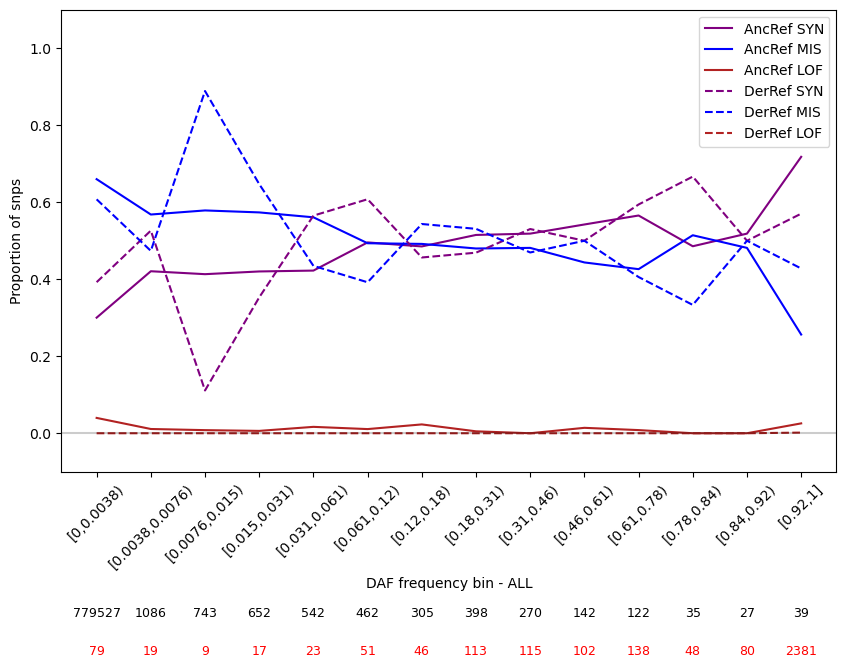

In [7]:
## Plot of proportions by frequency bin - top row # AncRef per bin, bottom (red) # DerRef per bin (similar to supp figure in Simons)
linestyle_map = {'AncRef':'-','DerRef':'--'}

plt.figure(figsize=(10,6))
for status in res_ALL['status'].unique():
    status_data = res_ALL[res_ALL['status'] == status]  
    plt.plot(status_data['DAF_bin'], status_data['prop_syn'], linestyle=linestyle_map[status], label=f'{status} SYN',color='purple')
    plt.plot(status_data['DAF_bin'], status_data['prop_mis'], linestyle=linestyle_map[status], label=f'{status} MIS',color='blue')
    plt.plot(status_data['DAF_bin'], status_data['prop_lof'], linestyle=linestyle_map[status], label=f'{status} LOF',color='firebrick')

for i, row in res_ALL[res_ALL['status'] == 'AncRef'].iterrows():
    plt.text(row['DAF_bin'], -0.45, str(row['num_snps']), ha='center', va='top', fontsize=9, color='black')

for i, row in res_ALL[res_ALL['status'] == 'DerRef'].iterrows():
    plt.text(row['DAF_bin'], -0.55, str(row['num_snps']), ha='center', va='top', fontsize=9, color='red')
    
plt.legend()
plt.ylim(-0.1,1.1)
plt.xticks(rotation=45)
plt.axhline(0,color='black',alpha=0.2)
plt.xlabel('DAF frequency bin - ALL')
plt.ylabel('Proportion of snps')
# plt.savefig('freq_binned_ALL_nosyn.pdf')
plt.show()

### Implement the bias correction procedure

In [8]:
## add the AncRef proportion info to dataframe for all variants (AncRef/DerRef)
prop_func_binned = res_ALL[res_ALL['status']=='AncRef']
df_freq_ALL_filt_props = df_freq_ALL_filt.merge(
    prop_func_binned[['DAF_bin', 'prop_lof','prop_syn','prop_mis']], 
    on='DAF_bin', 
    how='left', 
    suffixes=('', '_anc')
)
# df_freq_ALL_filt_props

In [9]:
# filter out alleles fixed in whole biobank
df_freq_ALL_filt_props = df_freq_ALL_filt_props[df_freq_ALL_filt_props['DAF']!=1]

In [11]:
## Function to implement bias correction

def bias_corr_freq(df_freq_ALL_filt_props, lof_file, mis_file, syn_file,rep=1):
    # Read the input files for each category (LOF, missense, synonymous) and format
    dflof = pd.read_csv(lof_file, sep='\t')
    dflof = dflof.rename(columns={'CHR': 'CHROM', 'Derived_Frequency': 'DAF_SIR'})
    df_all_lof = df_freq_ALL_filt_props.merge(dflof, on=['CHROM','POS'], how='inner', suffixes=('', '_sir'))
    df_all_lof_rep = df_all_lof[df_all_lof['ITER'] == rep]

    dfmis = pd.read_csv(mis_file, sep='\t')
    dfmis = dfmis.rename(columns={'CHR': 'CHROM', 'Derived_Frequency': 'DAF_SIR'})
    df_all_mis = df_freq_ALL_filt_props.merge(dfmis, on=['CHROM', 'POS'], how='inner', suffixes=('', '_sir'))
    df_all_mis_rep = df_all_mis[df_all_mis['ITER'] == rep]

    dfsyn = pd.read_csv(syn_file, sep='\t')
    dfsyn = dfsyn.rename(columns={'CHR': 'CHROM', 'Derived_Frequency': 'DAF_SIR'})
    df_all_syn = df_freq_ALL_filt_props.merge(dfsyn, on=['CHROM', 'POS'], how='inner', suffixes=('', '_sir'))
    df_all_syn_rep = df_all_syn[df_all_syn['ITER'] == rep]

    # Combine the data
    df_all_rep = pd.concat([df_all_syn_rep, df_all_mis_rep, df_all_lof_rep])
    
    # Subset the relevant columns
    df_all_rep_sub = df_all_rep[['CHROM', 'POS', 'Functional_cat', 'status', 'DAF', 'DAF_SIR', 'prop_lof', 'prop_mis', 'prop_syn']]

    # Split by AncRef and DerRef
    df_AncRef = df_all_rep_sub[df_all_rep_sub['status'] == 'AncRef']
    df_DerRef = df_all_rep_sub[df_all_rep_sub['status'] == 'DerRef']

    # Assign the DAF to the corresponding functional category for AncRef variants
    df_AncRef['weighted_daf_lof'] = df_AncRef.apply(lambda row: row['DAF_SIR'] if row['Functional_cat'] == 'LoF' else np.nan, axis=1)
    df_AncRef['weighted_daf_mis'] = df_AncRef.apply(lambda row: row['DAF_SIR'] if row['Functional_cat'] == 'Missense' else np.nan, axis=1)
    df_AncRef['weighted_daf_syn'] = df_AncRef.apply(lambda row: row['DAF_SIR'] if row['Functional_cat'] == 'Synonymous' else np.nan, axis=1)

    # For DerRef variants, calculate the weighted DAF for each category
    df_DerRef['weighted_daf_lof'] = df_DerRef['DAF_SIR'] * df_DerRef['prop_lof'] 
    df_DerRef['weighted_daf_mis'] = df_DerRef['DAF_SIR'] * df_DerRef['prop_mis']
    df_DerRef['weighted_daf_syn'] = df_DerRef['DAF_SIR'] * df_DerRef['prop_syn']

    # Combine AncRef and DerRef dataframes
    df_combined = pd.concat([df_AncRef, df_DerRef], axis=0)

    # Return the combined dataframe with the weighted DAFs
    return df_combined


In [12]:
## Function to plot bias corrected heterozygosity (approximated as 2*DAF)

def plot_bias_corrected_het_for_scenarios(df_freq_ALL_filt_props,segregating_only=False,corr_factor=0.19):
    plt.figure(figsize=(12, 6))
    
    # Order of sampling scenarios
    custom_order = [
        'centerE16N4geo50000', 'centerE16N4geo100000', 'centerE16N4geo150000',
        'centerE9N9geo50000', 'centerE9N9geo100000', 'centerE9N9geo150000',
        'centerE6N4geo50000', 'centerE6N4geo100000', 'centerE6N4geo150000',
        'uniformgeo',
        'centerX19Y4pca0.0015', 'centerX19Y4pca0.0025', 'centerX19Y4pca0.005',
        'uniformpca'
    ]
    
    # Colors for each category
    colors = {'LOF': 'darkorange', 'Missense': 'orchid', 'Synonymous': 'steelblue'}
    
    # Initialize lists to hold mean frequencies and standard deviations
    means_lof = []
    means_mis = []
    means_syn = []
    stds_lof = []
    stds_mis = []
    stds_syn = []

    # Loop through each scenario
    for scenario in custom_order:
        # Construct file paths for LOF, Missense, and Synonymous
        lof_file = f'../results/daf/chr1_lof_{scenario}_nSIR10000_nSIRreps10.daf'
        mis_file = f'../results/daf/chr1_missense_{scenario}_nSIR10000_nSIRreps10.daf'
        syn_file = f'../results/daf/chr1_synonymous_{scenario}_nSIR10000_nSIRreps10.daf'
        
        # Collect mean DAF values across replicates
        lof_freqs = []
        mis_freqs = []
        syn_freqs = []
        
        # Loop through replicates 1 through 10
        for rep in range(1, 11):
            # Get the corrected data for the current replicate
            df_combined_rep = bias_corr_freq(df_freq_ALL_filt_props, lof_file, mis_file, syn_file,rep)
            if segregating_only:
                df_combined_rep = df_combined_rep[(df_combined_rep['DAF_SIR'] > 0)&(df_combined_rep['DAF_SIR'] < 1)]
            # fold back to mafs
            df_combined_rep['weighted_maf_lof'] = df_combined_rep['weighted_daf_lof'].apply(lambda x: 1 - x if x > 0.5 else x)
            df_combined_rep['weighted_maf_mis'] = df_combined_rep['weighted_daf_mis'].apply(lambda x: 1 - x if x > 0.5 else x)
            df_combined_rep['weighted_maf_syn'] = df_combined_rep['weighted_daf_syn'].apply(lambda x: 1 - x if x > 0.5 else x)
            
            # Calculate the means for each functional category
            mean_lof = 2*df_combined_rep['weighted_maf_lof'].mean()*corr_factor
            mean_mis = 2*df_combined_rep['weighted_maf_mis'].mean()*corr_factor
            mean_syn = 2*df_combined_rep['weighted_maf_syn'].mean()*corr_factor
            
            # Append to the lists
            lof_freqs.append(mean_lof)
            mis_freqs.append(mean_mis)
            syn_freqs.append(mean_syn)
        
        # Calculate the mean and standard deviation of the means across replicates
        means_lof.append(np.mean(lof_freqs))
        means_mis.append(np.mean(mis_freqs))
        means_syn.append(np.mean(syn_freqs))
        stds_lof.append(np.std(lof_freqs))
        stds_mis.append(np.std(mis_freqs))
        stds_syn.append(np.std(syn_freqs))

    # print(means_lof)
    # print(means_mis)
    # print(means_syn)
    
    # Plot the results
    plt.errorbar(custom_order, means_lof, yerr=stds_lof, fmt='o', capsize=5, color=colors['LOF'], ecolor='black', label='LOF')
    plt.errorbar(custom_order, means_mis, yerr=stds_mis, fmt='o', capsize=5, color=colors['Missense'], ecolor='black', label='Missense')
    plt.errorbar(custom_order, means_syn, yerr=stds_syn, fmt='o', capsize=5, color=colors['Synonymous'], ecolor='black', label='Synonymous')
    df_results = pd.DataFrame({'Scenario': custom_order, 'Mean_LOF': means_lof, 'Std_LOF': stds_lof, 'Mean_Missense':means_mis,'Std_Missense':stds_mis,'Mean_Synonymous':means_syn,'Std_Synonymous':stds_syn})
    if segregating_only:
        df_results.to_csv('bias_corrected_het_results_segregatingonly_v20250324.csv', index=False)
    else:
        df_results.to_csv('bias_corrected_het_results_allvariants_v20250324.csv', index=False)
    # Final plot adjustments
    plt.xticks(rotation=90)
    if segregating_only:
        plt.title("Avg. Heterozygosity (Bias-corrected) across scenarios - segregating variants only")
    else:
        plt.title("Avg. Heterozygosity (Bias-corrected) across scenarios")
    plt.ylabel("Avg. Heterozygosity")
    plt.legend()
    plt.tight_layout()
    plt.yscale('log')
    plt.ylim(1e-4, 1e0)
    plt.show()
    
    # Get indices for comparisons
    idx_uniformgeo = custom_order.index('uniformgeo')
    idx_uniformpca = custom_order.index('uniformpca')
    idx_pca_0015 = custom_order.index('centerX19Y4pca0.0015')
    idx_geo_50000 = custom_order.index('centerE16N4geo50000')
    idx_geo_50000_2 = custom_order.index('centerE9N9geo50000')
    
    # Print percent change from uniformgeo to uniformpca
    print("\nPercent change from uniformgeo to uniformpca:")
    print(f"LOF: {((means_lof[idx_uniformpca] - means_lof[idx_uniformgeo]) / means_lof[idx_uniformgeo]) * 100:.2f}%")
    print(f"Missense: {((means_mis[idx_uniformpca] - means_mis[idx_uniformgeo]) / means_mis[idx_uniformgeo]) * 100:.2f}%")
    print(f"Synonymous: {((means_syn[idx_uniformpca] - means_syn[idx_uniformgeo]) / means_syn[idx_uniformgeo]) * 100:.2f}%")
    
    # Print percent change from uniformgeo to centerX19Y4pca0.0015
    print("\nPercent change from uniformgeo to centerX19Y4pca0.0015:")
    print(f"LOF: {((means_lof[idx_pca_0015] - means_lof[idx_uniformgeo]) / means_lof[idx_uniformgeo]) * 100:.2f}%")
    print(f"Missense: {((means_mis[idx_pca_0015] - means_mis[idx_uniformgeo]) / means_mis[idx_uniformgeo]) * 100:.2f}%")
    print(f"Synonymous: {((means_syn[idx_pca_0015] - means_syn[idx_uniformgeo]) / means_syn[idx_uniformgeo]) * 100:.2f}%")
    
    # Print percent change from centerE16N4geo50000 to uniformgeo
    print("\nPercent change from centerE16N4geo50000 to uniformgeo:")
    print(f"LOF: {((means_lof[idx_uniformgeo] - means_lof[idx_geo_50000]) / means_lof[idx_geo_50000]) * 100:.2f}%")
    print(f"Missense: {((means_mis[idx_uniformgeo] - means_mis[idx_geo_50000]) / means_mis[idx_geo_50000]) * 100:.2f}%")
    print(f"Synonymous: {((means_syn[idx_uniformgeo] - means_syn[idx_geo_50000]) / means_syn[idx_geo_50000]) * 100:.2f}%")

     # Print percent change from centerE9N9geo50000 to uniformgeo
    print("\nPercent change from centerE9N9geo50000 to uniformgeo:")
    print(f"LOF: {((means_lof[idx_uniformgeo] - means_lof[idx_geo_50000_2]) / means_lof[idx_geo_50000_2]) * 100:.2f}%")
    print(f"Missense: {((means_mis[idx_uniformgeo] - means_mis[idx_geo_50000_2]) / means_mis[idx_geo_50000_2]) * 100:.2f}%")
    print(f"Synonymous: {((means_syn[idx_uniformgeo] - means_syn[idx_geo_50000_2]) / means_syn[idx_geo_50000_2]) * 100:.2f}%")
    
    # Print percent change from centerX19Y4pca0.0015 to uniformpca
    print("\nPercent change from centerX19Y4pca0.0015 to uniformpca:")
    print(f"LOF: {((means_lof[idx_uniformpca] - means_lof[idx_pca_0015]) / means_lof[idx_pca_0015]) * 100:.2f}%")
    print(f"Missense: {((means_mis[idx_uniformpca] - means_mis[idx_pca_0015]) / means_mis[idx_pca_0015]) * 100:.2f}%")
    print(f"Synonymous: {((means_syn[idx_uniformpca] - means_syn[idx_pca_0015]) / means_syn[idx_pca_0015]) * 100:.2f}%")
    
    # Print percent change from centerE16N4geo50000 to uniformpca
    print("\nPercent change from centerE16N4geo50000 to uniformpca:")
    print(f"LOF: {((means_lof[idx_uniformpca] - means_lof[idx_geo_50000]) / means_lof[idx_geo_50000]) * 100:.2f}%")
    print(f"Missense: {((means_mis[idx_uniformpca] - means_mis[idx_geo_50000]) / means_mis[idx_geo_50000]) * 100:.2f}%")
    print(f"Synonymous: {((means_syn[idx_uniformpca] - means_syn[idx_geo_50000]) / means_syn[idx_geo_50000]) * 100:.2f}%")


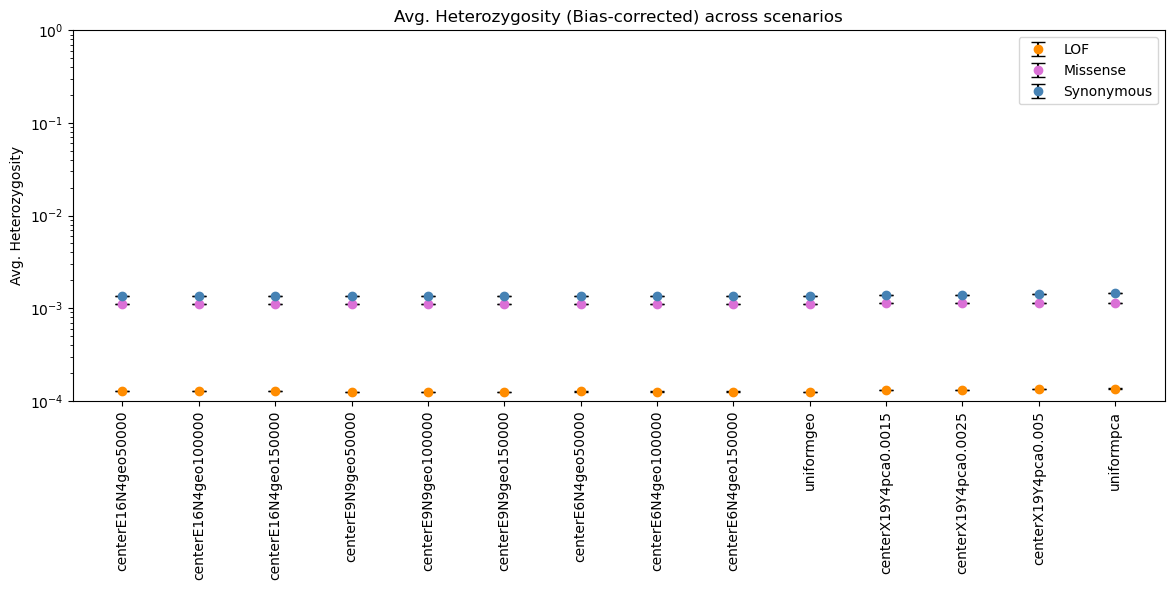


Percent change from uniformgeo to uniformpca:
LOF: 7.94%
Missense: 1.35%
Synonymous: 8.09%

Percent change from uniformgeo to centerX19Y4pca0.0015:
LOF: 3.45%
Missense: 0.52%
Synonymous: 2.19%

Percent change from centerE16N4geo50000 to uniformgeo:
LOF: -0.58%
Missense: -0.05%
Synonymous: -0.06%

Percent change from centerE9N9geo50000 to uniformgeo:
LOF: 0.06%
Missense: -0.01%
Synonymous: 0.10%

Percent change from centerX19Y4pca0.0015 to uniformpca:
LOF: 4.34%
Missense: 0.83%
Synonymous: 5.78%

Percent change from centerE16N4geo50000 to uniformpca:
LOF: 7.31%
Missense: 1.30%
Synonymous: 8.03%


In [13]:
## call plotting function - all variants
plot_bias_corrected_het_for_scenarios(df_freq_ALL_filt_props)

### Segregating variants only

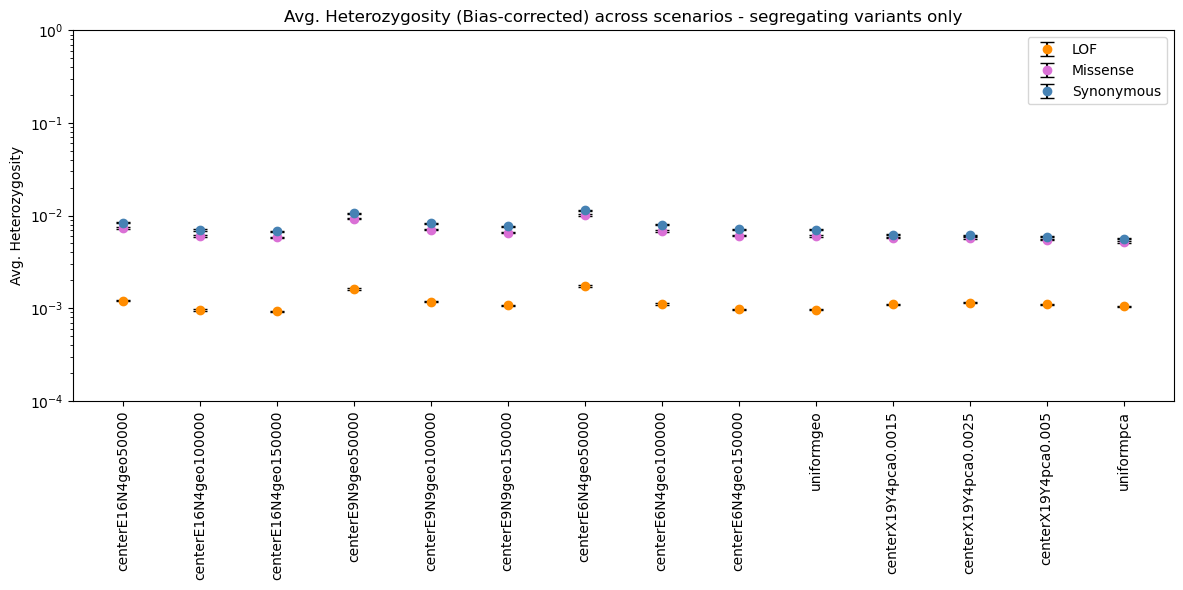


Percent change from uniformgeo to uniformpca:
LOF: 9.35%
Missense: -13.75%
Synonymous: -19.87%

Percent change from uniformgeo to centerX19Y4pca0.0015:
LOF: 14.26%
Missense: -3.41%
Synonymous: -11.50%

Percent change from centerE16N4geo50000 to uniformgeo:
LOF: -20.17%
Missense: -18.31%
Synonymous: -16.16%

Percent change from centerE9N9geo50000 to uniformgeo:
LOF: -40.46%
Missense: -34.85%
Synonymous: -33.81%

Percent change from centerX19Y4pca0.0015 to uniformpca:
LOF: -4.30%
Missense: -10.70%
Synonymous: -9.46%

Percent change from centerE16N4geo50000 to uniformpca:
LOF: -12.70%
Missense: -29.54%
Synonymous: -32.82%


In [14]:
## call plotting function - segregating only
plot_bias_corrected_het_for_scenarios(df_freq_ALL_filt_props,segregating_only=True)